In [1]:
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import torch
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf
import gpzoo.pri_experiment_utilities as putil
from gpzoo.gp import SVGP, VNNGP, GaussianPrior
from gpzoo.likelihoods import PNMF
import scanpy as sc
from os import path
import random
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
from torch import optim, distributions, nn
from sklearn.metrics import root_mean_squared_error, mean_poisson_deviance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import ast
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.utils import resample

import gseapy as gps
from gseapy.plot import barplot, dotplot
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda

import warnings
warnings.filterwarnings("ignore") 

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-11-08 12:43:44.427540: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 12:43:44.440716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 12:43:44.458318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 12:43:44.458342: E external/l

In [2]:
X, Y = putil.load_visium()

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, Y.T, test_size=0.05, random_state=256)

In [4]:
adata = sq.datasets.visium_hne_adata()
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(256)
random_seed = 256

ROOT_PATH = '/engelhardt/home/pshrestha/vnngp/'
RPATH = path.join(ROOT_PATH, "results/")
SPATH = path.join(RPATH, "visium/")
FPATH = path.join(SPATH, "plots/")

In [6]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, 'nmf_factors_iter=1000_rs=256_L=10.npy')
loadings_path = path.join(nmf_save_path, 'nmf_loadings_iter=1000_rs=256_L=10.npy')
factors = np.load(factors_path)
loadings = np.load(loadings_path)
factors_path_train = path.join(nmf_save_path, 'train_nmf_factors_iter=1000_rs=256_L=10.npy')
loadings_path_train = path.join(nmf_save_path, 'train_nmf_loadings_iter=1000_rs=256_L=10.npy')
factors_train = np.load(factors_path_train)
loadings_train = np.load(loadings_path_train)

In [7]:
root_path = '/engelhardt/home/pshrestha/vnngp/'
nnnsf_path = path.join(root_path, 'results/visium/nnnsf')
nnnsfh_path = path.join(root_path, 'results/visium/nnnsfh')
nsfh_path = path.join(root_path, 'results/visium/nsfh')
nsf_path = path.join(root_path, 'results/visium/nsf')

### Functions

In [9]:
def calculate_reconstruction_error_squared(W, X, Y,):
    W_transformed = nn.functional.softplus(W.T)
    y_nnnsf = (np.exp(means.T)).dot(W_transformed.detach().numpy())
    print("reconstruction shape: ", y_nnnsf.shape)
    print("actual shape: ", Y.shape)
    return root_mean_squared_error(y_nnnsf, Y.T)
    

In [10]:
def calculate_variance_explained(W, X, Y, factor_num=None):
    """
    Calculate the amount of variance captured by each factor.

    Parameters:
    model : nn.Module
        Trained VNNGP model.
    X : torch.Tensor
        Original data matrix of size [N, D].
    Y : torch.Tensor
        Response matrix of size [L, N].

    Returns:
    explained_variance_ratios : np.ndarray
        Proportion of variance explained by each factor.
    """
    W_transformed = nn.functional.softplus(W.T)
    y_nnnsf = (np.exp(means.T)).dot(W_transformed.detach().numpy())

    # Calculate the variance captured by each factor
    fvariances = np.var(means, axis=1)

    # Calculate ratio of actual/output variance explaine
    total_model_var = np.var(y_nnnsf, axis=0)
    Y = np.array(Y)
    total_actual_var = np.var(Y, axis=1)
    var_ratios =  (total_model_var.sum() / y_nnnsf.shape[0]) / (total_actual_var.sum() / Y.shape[1])

    if factor_num != None:
        return fvariances[factor_num], var_ratios
    
    return fvariances, var_ratios


In [11]:
def average_rmse(A, B):
    A = np.array(A)
    B = np.array(B)
    return (np.sqrt((A.flatten() - (B.T).flatten())**2).sum()) / (A.shape[0]*A.shape[1])

In [12]:
def calculate_eval_metric(X, Y, param_dict, datapath, eval_function=root_mean_squared_error, train=False, X_val=False, hybrid=False):
    X_train, X_val, y_train, y_val = train_test_split(X, Y.T, test_size=0.05, random_state=256)
    L = param_dict['L']
    M = param_dict['M']
    K = param_dict['K']
    inducing_point_rmse = []
    neighbor_rmse = []
    data_dict = {
        str(L[0]) : [],
        str(L[1]) : [],
        str(L[2]): [],
    }
    
    for l in L:
        inducing_point_rmse = []
        for m in M:
            neighbor_rmse  = []
            for k in K:
                dicts = {
                'L': l, 
                'M': m, 
                'K': k,
                'sigma': param_dict['sigma'], 
                'lengthscale': param_dict['lengthscale'], 
                'jtr': param_dict['jtr'],
                'batch_size': 128,
                'lr': param_dict['lr'],
                'rs': 256,
                'lkzz_build': 1,
                'model': param_dict['model'],
                'L1_jitter': param_dict['L1_jitter']}
        
                nmf_save_path = path.join(SPATH, 'nmf')
                if train:
                    print("Loading model on training data")
                    factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
                    loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
                else:
                    factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
                    loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
                    
                factors = np.load(factors_path)
                loadings = np.load(loadings_path)
                if not hybrid:
                    if train:
                        model = putil.build_model(X_train, y_train.T, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                    else:
                        model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                else:
                    model = putil.build_model_hybrid(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                    
                
                filepath = f"VNNGP_K={k}_lkzz=1_M={m}_L={l}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs=128_NMFinit_state_dict.pth"
                dictpath = path.join(datapath, filepath)
                print(dictpath)
                if not path.exists(dictpath):
                    print("Does not exist.")
                    neighbor_rmse.append(np.nan)
                    continue
                
                model.load_state_dict(torch.load(dictpath))

                if train:
                    X_train = torch.tensor(X_train).type(torch.float)
                    X_val = torch.tensor(X_val).type(torch.float)
                    train_loss = putil.evaluate_model(model, X_train.cpu(), y_train.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
                
                    val_loss = putil.evaluate_model(model, X_val.cpu(), y_val.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
                    loss = (train_loss, val_loss)
                else:
                    X = torch.tensor(X).type(torch.float)
                    X = X.clone().detach().type(torch.float)
                    loss = putil.evaluate_model(model, X.cpu(), Y.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
    
                print(f"With {l} factors and {k}  neighbors: ", loss)
                neighbor_rmse.append(loss)
            inducing_point_rmse.append(neighbor_rmse)
        data_dict[str(l)] = inducing_point_rmse
        print(f"DONE with factor {l}")
    return data_dict

In [13]:
def calculate_eval_metric_nsf(X, Y, param_dict, datapath, eval_function=root_mean_squared_error, train=False, X_val=False, hybrid=False):
    L = param_dict['L']
    M = param_dict['M']
    inducing_point_rmse = []
    neighbor_rmse = []
    data_dict = {
        str(L[0]) : [],
        str(L[1]) : [],
        str(L[2]): [],
    }
    
    for l in L:
        inducing_point_rmse = []
        for m in M:
            neighbor_rmse  = []
            dicts = {
                'L': l, 
                'M': m, 
                'sigma': param_dict['sigma'], 
                'lengthscale': param_dict['lengthscale'], 
                'jtr': param_dict['jtr'],
                'batch_size': 64,
                'lr': param_dict['lr'],
                'rs': 256,
                'lkzz_build': 1,
                'model': param_dict['model'],
                'L1_jitter': param_dict['L1_jitter']}
        
            nmf_save_path = path.join(SPATH, 'nmf')
            if train:
                print("Loading model on training data")
                factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
                loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
            else:
                factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
                loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
                    
            factors = np.load(factors_path)
            loadings = np.load(loadings_path)
            if not hybrid:
                if train:
                    model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                else:
                    model = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                #putil.model_grads(model)
                #model.prior.jitter = dicts['jtr']
            else:
                model = putil.build_model_hybrid(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
                #putil.model_grads_hybrid(model)
                #model.sf.prior.jitter = dicts['jtr']
                    
                
            filepath = f"SVGP_M={m}_L={l}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs={dicts['batch_size']}_NMFinit_state_dict.pth"
            dictpath = path.join(datapath, filepath)
            print(dictpath)
            if not path.exists(dictpath):
                print("Does not exist.")
                neighbor_rmse.append(np.nan)
                continue
                
            model.load_state_dict(torch.load(dictpath))

            if train:
                X_train = torch.tensor(X).type(torch.float)
                X_val = torch.tensor(X_val).type(torch.float)
                train_loss = putil.evaluate_model(model, X_train.cpu(), y_train.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
                
                val_loss = putil.evaluate_model(model, X_val.cpu(), y_val.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
                loss = (train_loss, val_loss)
            else:
                X = torch.tensor(X).type(torch.float)
                X = X.clone().detach().type(torch.float)
                loss = putil.evaluate_model(model, X.cpu(), Y.T, device, evaluation_metric=eval_function,
                                  kwargs=dicts)
    
            print(f"With {l} factors and {m}  IPs: ", loss)
            inducing_point_rmse.append(loss)
        data_dict[str(l)] = inducing_point_rmse
        print(f"DONE with factor {l}")
    return data_dict

In [14]:
def plot_one_factor(factors, X, factor_num, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)
    factors = factors[moran_idx]
    ax.scatter(X[:, 0], X[:,1], c=factors[factor_num], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('xkcd:gray')

### Run Times

In [19]:
# compare runntime with VNNGP (different K) versus SVGP
fig, ax = plt.subplots(figsize=(5,4), sharey=True, sharex=True)
times = []
M = [50, 1000, 2000, 2688]
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500]
# NMF
#file_path = path.join(rpth, f"visium/nmf/nmf_factors_iter=1000_rs=256_L=5.pt")
#results = torch.load(file_path)
#plt.axhline(y=results['time'], color='black', linestyle='--', linewidth=1, label='NMF')

# PNMF
#file_path = path.join(rpth, f"visium/pnmf/PNMF_L=5_lr=0.1_iter=6000_model.pt")
#results = torch.load(file_path)
#plt.axhline(y=results['time'], color='black', linestyle=':', linewidth=1, label='PNMF')

times = []

# compare runntime with VNNGP (different K) versus SVGP
# NMF
#file_path = path.join(RPATH, f"visium/nmf/nmf_factors_iter=1000_rs=256_L=5.pt")
#results = torch.load(file_path)
#plt.axhline(y=results['time'], color='black', linestyle='--', linewidth=1, label='NMF')

# PNMF
#file_path = path.join(rpth, f"visium/pnmf/PNMF_L=5_lr=0.1_iter=6000_model.pt")
#results = torch.load(file_path)
#plt.axhline(y=results['time'], color='black', linestyle=':', linewidth=1, label='PNMF')

times = []
# VNNGP
for k in K:
    times = []
    ip = []
    for m in M:
        file_path = path.join(nnnsf_path, 
                           f"VNNGP_K={k}_lkzz=1_M={m}_L=10_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_model.pt")
        if path.exists(file_path):
            #print("NNNSF")
            results = torch.load(file_path)
            #print(len(results['losses']))
            times.append(results['time'])
            ip.append(m)
    sns.lineplot(x=ip, y=times, label=f"K={k}", alpha=0.8, legend=False)


# SVGP
times = []
M = [50, 1000, 2000, 2553]
for m in M:
    file_path = path.join(nsf_path, 
                               f"validation_experiments/SVGP_M={m}_L=10_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_model.pt")
    results = torch.load(file_path)
    #print(len(results['losses']))
    times.append(results['time'] / 5)
sns.lineplot(x=M, y=times, color='black', label='NSF', linewidth=2, legend=False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', frameon=False, bbox_to_anchor=(0.9, 0.5))

ax.set_xticks([50, 1000, 2000, len(X)])
ax.set_ylabel("Time (seconds)")
ax.set_xlabel('IPs', fontsize=12)
sns.despine()
plt.show()
fig.savefig(f'{FPATH}/visium_nonhybrid_run_time.png', bbox_inches='tight')
#plt.close()

### Factors

In [22]:
names = [int(i+1) for i in range(15)]
print(names)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [23]:
dicts = {
            'L': 10, 
            'M': len(X_train), 
            'K': 4,
            'sigma': 1.0, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

NNNSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
putil.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']

file_path = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

X = torch.tensor(X).type(torch.float)
rmse = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors

#size=2
#fig1, axes1 = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)

moran_idx = moran_idx.astype(int)
fig2, ax = putil.plot_factors(means, X.cpu().detach().numpy(), size=1.5, s=0.3, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(names)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NNNSF M=N, K=4", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

Iterations:  5000
Runtime:  210.09850144386292
RMSE:  2.1793284382725098
Poisson Deviance:  1.7217710367688026
(2, 5)


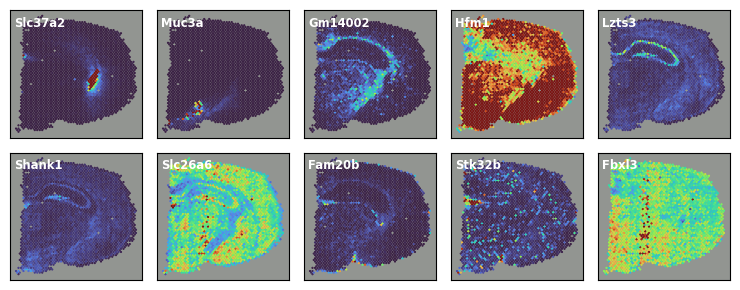

In [35]:
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_train))
factors = factors[:, moran_idx]
loadings = loadings[:, moran_idx]
loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
names = adata.var.index[loadings_softmax.argmax(axis=0)]
fig, ax = putil.plot_factors(Y[loadings_softmax.argmax(axis=0)], np.array(X), size=1.5, s=0.3, alpha=1, names=None)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(names)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_genes.png")

Iterations:  5000
Runtime:  98.1961236000061
RMSE:  2.1995218881785217
Poisson Deviance:  1.73834987398017
(2, 5)


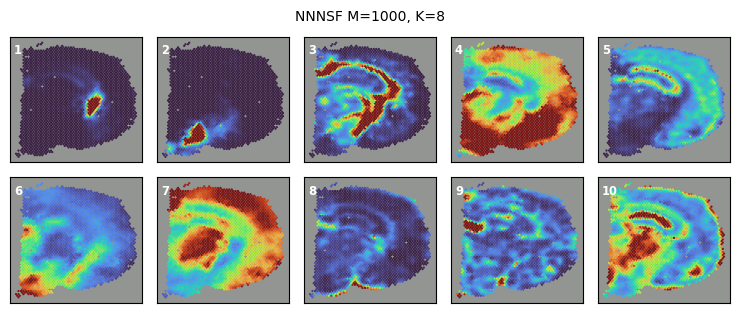

In [38]:
dicts = {
            'L': 10, 
            'M': 1000, 
            'K': 8,
            'sigma': 1.0, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}


nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

NNNSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
putil.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']

file_path = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

X = torch.tensor(X).type(torch.float)
rmse = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors

#size=2
#fig1, axes1 = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)

moran_idx = moran_idx.astype(int)
fig2, ax = putil.plot_factors(means, X.cpu().detach().numpy(), size=1.5, s=0.3, alpha=1, ax=None, names=None)
print(ax.shape)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(names)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle(f"NNNSF M={dicts['M']}, K={dicts['K']}", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}.png")
#plt.close()

### NSF

In [39]:
dicts = {
            'L': 10, 
            'M': len(X_train), 
            'K': 4,
            'sigma': 1.01, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'SVGP',
            'L1_jitter': 1e-1}

Iterations:  5000
Runtime:  98.1961236000061
RMSE:  2.355997770697333
Poisson Deviance:  2.205595445544878


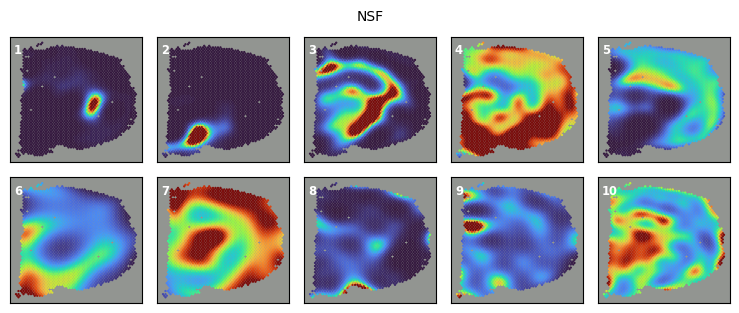

In [43]:
nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, 'train_nmf_factors_iter=1000_rs=256_L=10.npy')
loadings_path = path.join(nmf_save_path, 'train_nmf_loadings_iter=1000_rs=256_L=10.npy')
factors = np.load(factors_path)
loadings = np.load(loadings_path)

NSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), kwargs=dicts)
putil.model_grads(NSF)
NSF.prior.jitter = dicts['jtr']


#print(loadings)
file_path = f"validation_experiments/SVGP_M={dicts['M']}_L=10_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth"
modelname = f"validation_experiments/SVGP_M={dicts['M']}_L=10_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_model.pt"
dict_path = path.join(nsf_path, file_path)
model_path = path.join(nsf_path, modelname)
model_dict = torch.load(model_path)

X = torch.tensor(X).type(torch.float)
rmse = putil.evaluate_model(NSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)


NSF.load_state_dict(torch.load(dict_path))
X = torch.tensor(X).type(torch.float)
X = X.clone().detach().type(torch.float)
NSF.cpu()
qF, _, _ = NSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

fig2, ax = putil.plot_factors(means, X.cpu().detach().numpy(), size=1.5, s=0.4, alpha=1, ax=None, names=None)
for i in range(len(ax.flatten())):
    curr_ax = ax[i//5, i%5]
    curr_ax.set_title(np.array(names)[i], x=0.03, y=.88, fontsize="small", c="white", ha="left", va="top", weight="bold")
fig2.suptitle("NSF", size=10, y=0.95)
fig2.set_figheight(3.25)
fig2.tight_layout()
fig2.savefig(f'{FPATH}/nsf_l=10,iter=5000_plot.png')

### By K

Processing K=1
Iterations:  5000
Runtime:  374.64992356300354
RMSE:  2.4152560384604436
Poisson Deviance:  2.1814559698123306
Moran's Idx:  [5 4 6 0 2 1 3 9 7 8]
Moran's I:  [0.97880526 0.95715939 0.95239545 0.94486618 0.94284213 0.93277037
 0.90843782 0.86070805 0.8175712  0.6075234 ]

Processing K=2
Iterations:  5000
Runtime:  381.7944962978363
RMSE:  2.2770166320794347
Poisson Deviance:  1.8851388876549204
Moran's Idx:  [5 6 4 2 3 1 0 9 7 8]
Moran's I:  [0.96249216 0.95108207 0.93110388 0.90890303 0.90640618 0.90233017
 0.88538833 0.83117248 0.78538156 0.7314781 ]

Processing K=3
Iterations:  5000
Runtime:  600.0947680473328
RMSE:  2.2221265969990776
Poisson Deviance:  1.7922842546217483
Moran's Idx:  [5 6 3 4 2 8 0 9 1 7]
Moran's I:  [0.96380841 0.94786115 0.91114859 0.90625736 0.90132155 0.86388242
 0.85392067 0.84005473 0.80457045 0.75853369]

Processing K=4
Iterations:  5000
Runtime:  210.09850144386292
RMSE:  2.203831431349226
Poisson Deviance:  1.7580056661066217
Moran's Idx: 

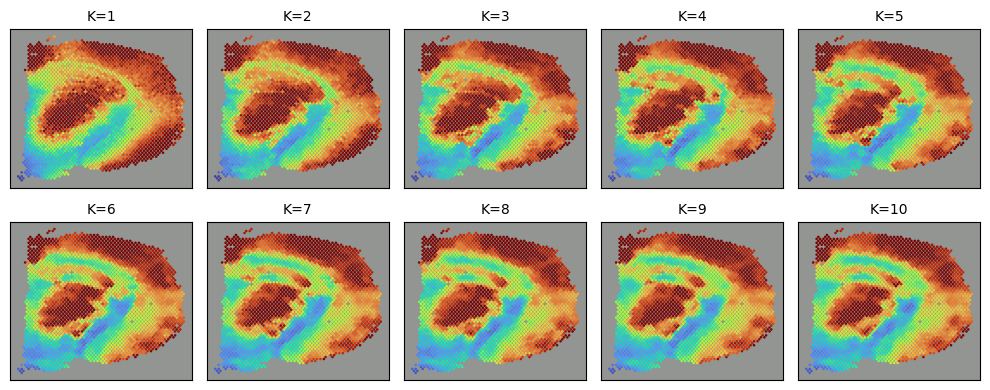

In [41]:
save_path = path.join(root_path, "results/visium/nnnsf/validation_experiments")
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
axes = axes.flatten()
L = len(factors)
rmses = []
deviances = []
runntimes = []
kmorans = []
for i,k in enumerate(K):
    print(f"Processing K={k}")
    dicts = {
        'L': 10, 
        'M': len(X_train), 
        'K': k,
        'sigma': 1.0, 
        'lengthscale': 1.0, 
        'jtr': 0.1,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'model': 'VNNGP',
        'lkzz_build': 1,
        'L1_jitter': 0.1}
    file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L=10_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
    model_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L=10_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
    dict_path = path.join(save_path, file_path)
    model_path = path.join(save_path, model_path)
    NNNSF = putil.build_model(X_train, y_train.T, loadings=loadings_train, factors=factors_train, kwargs=dicts)
    putil.model_grads(NNNSF)
    NNNSF.prior.jitter = dicts['jtr']
    NNNSF.load_state_dict(torch.load(dict_path))
    model_dict = torch.load(model_path)

    X = torch.tensor(X).type(torch.float)
    rmse = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                      kwargs=dicts)
    poid = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                      kwargs=dicts)
    
    print("Iterations: ", len(model_dict['losses']))
    print("Runtime: ", (model_dict['time']))
    print("RMSE: ", rmse)
    print("Poisson Deviance: ", poid)
    deviances.append(poid)
    runntimes.append(model_dict['time'])
    rmses.append(rmse)
    
    
    X = torch.tensor(X).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NNNSF.cpu()
    qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    moran_idx, moranI = putil.dims_autocorr(means.T, X)
    print("Moran's Idx: ", moran_idx)
    print("Moran's I: ", moranI)
    print("")
    factor = 0
    if i == 0:
        factor=2
        morans = moranI[2]
        kmorans.append(morans)
    else:
        factor=1
        morans=moranI[1]
        kmorans.append(morans)
    
    curr_ax = axes[i]
    plot_one_factor(means, X, factor, moran_idx=moran_idx, ax=curr_ax, size=1.5, s=0.7, alpha=1)
    #fvariance, ratio = calculate_variance_explained(NNNSF, X, 2)
    curr_ax.set_title(f"K={k}", size=10)

#fig.suptitle("Cortex Region Representation with Varying Number of Neighbors")
#ppath = path.join(save_path, 'plots'
fig.savefig(f'{SPATH}/factors_k_plot_2.png')

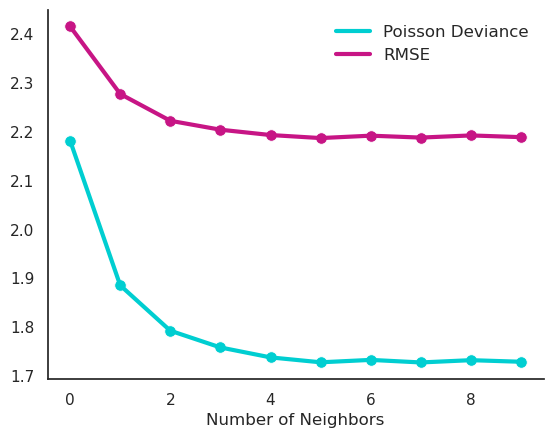

In [118]:
fix, ax = plt.subplots()
sns.set(style="white")

sns.scatterplot(deviances, color='darkturquoise', s=70)
sns.lineplot(deviances, linewidth=3, color='darkturquoise', label='Poisson Deviance')
sns.scatterplot(rmses, color='mediumvioletred', s=70)
sns.lineplot(rmses, linewidth=3, color='mediumvioletred', label='RMSE')
ax.set_xlabel("Number of Neighbors", fontsize=12)

legend = ax.legend(frameon=False, fontsize=12)

sns.despine()
fig.savefig(f'{SPATH}/factors_reconstruction.png')

Processing K=1
Iterations:  5000
Runtime:  374.64992356300354
RMSE:  2.4152560384604436
Poisson Deviance:  2.1814559698123306
Processing K=2
Iterations:  5000
Runtime:  381.7944962978363
RMSE:  2.2770166320794347
Poisson Deviance:  1.8851388876549204
Processing K=3
Iterations:  5000
Runtime:  600.0947680473328
RMSE:  2.2221265969990776
Poisson Deviance:  1.7922842546217483
Processing K=4
Iterations:  5000
Runtime:  210.09850144386292
RMSE:  2.203831431349226
Poisson Deviance:  1.7580056661066217
Processing K=5
Iterations:  5000
Runtime:  624.8438241481781
RMSE:  2.1929287716786425
Poisson Deviance:  1.7376609092701536
Processing K=6
Iterations:  5000
Runtime:  328.4540033340454
RMSE:  2.186720770974969
Poisson Deviance:  1.7276175438111612
Processing K=7
Iterations:  5000
Runtime:  328.48841285705566
RMSE:  2.191629539042354
Poisson Deviance:  1.732534884756894
Processing K=8
Iterations:  5000
Runtime:  326.2285270690918
RMSE:  2.1877131497242264
Poisson Deviance:  1.727311158057658
Pr

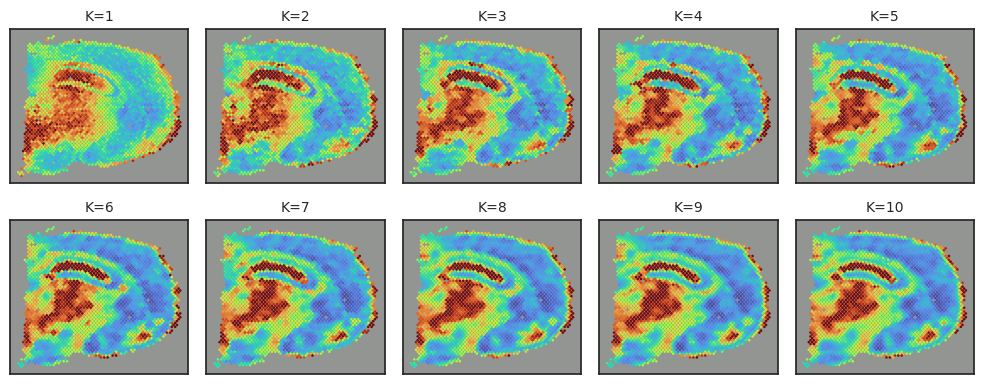

In [152]:
save_path = path.join(root_path, "results/visium/nnnsf/validation_experiments")
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
axes = axes.flatten()
L = len(factors)

for i,k in enumerate(K):
    print(f"Processing K={k}")
    dicts = {
        'L': 10, 
        'M': len(X_train), 
        'K': k,
        'sigma': 1.0, 
        'lengthscale': 1.0, 
        'jtr': 0.1,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'model': 'VNNGP',
        'lkzz_build': 1,
        'L1_jitter': 0.1}
    file_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L=10_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
    model_path = f"VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L=10_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
    dict_path = path.join(save_path, file_path)
    model_path = path.join(save_path, model_path)
    
    NNNSF = putil.build_model(X_train, y_train.T, loadings=loadings, factors=factors, kwargs=dicts)
    NNNSF.load_state_dict(torch.load(dict_path))
    model_dict = torch.load(model_path)

    X = torch.tensor(X).type(torch.float)
    rmse = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                      kwargs=dicts)
    poid = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                      kwargs=dicts)

    print("Iterations: ", len(model_dict['losses']))
    print("Runtime: ", (model_dict['time']))
    print("RMSE: ", rmse)
    print("Poisson Deviance: ", poid)
    
    X = torch.tensor(X).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NNNSF.cpu()
    qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    
    curr_ax = axes[i]
    plot_one_factor(means, X, 7, moran_idx=moran_idx, ax=curr_ax, size=1.5, s=0.7, alpha=1)
    #fvariance, ratio = calculate_variance_explained(NNNSF, X, 2)
    curr_ax.set_title(f"K={k}", size=10)

#fig.suptitle("Cortex Region Representation with Varying Number of Neighbors")
#ppath = path.join(save_path, 'plots'
fig.savefig(f'{SPATH}/factors_k_plot_1.png')

## RMSE, PD with ls = 1.0, sigma = 1.0

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, Y.T, test_size=0.05, random_state=256)

In [61]:
L = [5, 10, 15]
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
M = [50, 1000, 2000, len(X)]

In [62]:

params = {
    'L' : L,
    'K' : K,
    'M' : M,
    'model': 'VNNGP',
    'jtr': 0.1,
    'lengthscale': 1.0,
    'sigma': 1.01,
    'L1_jitter':0.1,
    'lr': 0.001,
}

'''
params = {
    'L' : L,
    'K' : K,
    'M' : M,
    'model': 'VNNGP',
    'jtr': 0.1,
    'lengthscale': 1.0,
    'sigma': 1.0,
    'L1_jitter':0.1,
    'lr': 0.001,
}
'''

"\nparams = {\n    'L' : L,\n    'K' : K,\n    'M' : M,\n    'model': 'VNNGP',\n    'jtr': 0.1,\n    'lengthscale': 1.0,\n    'sigma': 1.0,\n    'L1_jitter':0.1,\n    'lr': 0.001,\n}\n"

In [63]:
X, Y

(array([[ 1.63816282,  0.85702094],
        [-0.4993993 , -2.10502943],
        [-1.36863946,  1.42458053],
        ...,
        [-0.97008416,  1.48775971],
        [-1.07906824,  0.54217804],
        [-0.20982808, -1.85283922]]),
 array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 4.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [3., 1., 2., ..., 4., 3., 6.],
        [0., 0., 0., ..., 2., 1., 0.]]))

In [343]:
# NNNSF Converged Experiments
datapath = nnnsf_path
eval_function = root_mean_squared_error
nnnsf_k_experiments = calculate_eval_metric(X, Y, params, datapath, eval_function=eval_function, train=False, X_val=True, hybrid=False)

/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=1_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 1  neighbors:  2.4768435595680156
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=2_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 2  neighbors:  2.373471878425575
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=3_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 3  neighbors:  2.350435486366141
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=4_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  2.332863095622468
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=5_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 5  neighbors:  2.3283616989619143
/engelhardt/h

KeyboardInterrupt: 

In [185]:
nnnsf_k_experiments_df = pd.DataFrame(nnnsf_k_experiments)
#nnnsf_k_experiments_df.index = M # 50 looks bad so we removed it

In [186]:
nnnsf_k_experiments_df

5  \
0  [2.4768435595680156, 2.373471878425575, 2.3504...   
1  [2.5439960968785016, 2.411813885607132, 2.3564...   
2  [2.545791166872471, 2.4243039651356875, 2.3727...   
3  [2.526490299272293, 2.4286460195465893, 2.3805...   

                                                  10  \
0  [2.4678724365734217, 2.347677085883659, 2.3246...   
1  [2.532471886828764, 2.3796381035553473, 2.3239...   
2  [2.541055305629841, 2.3952882557012853, 2.3358...   
3  [2.508979947224522, 2.3967487482146654, 2.3422...   

                                                  15  
0  [2.5026510275722123, 2.3535154901563464, 2.331...  
1  [2.5757430561363917, 2.3994888837508883, 2.327...  
2  [2.5861780505798726, 2.4292296688426087, 2.344...  
3  [2.564641257485815, 2.4411596904146173, 2.3582...

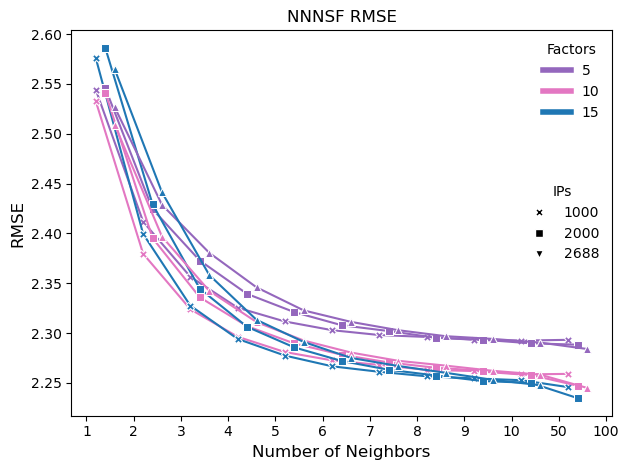

In [34]:
from matplotlib.lines import Line2D

ax = plt.axes() 

nnnsfh_df = nnnsf_k_experiments_df
x = np.arange(len(K))  # The x locations for the groups
width = 0.2  # The width of the bars

marker = {
    50: 'o',
    1000: 'X',
    2000: 's',
    2688: '^'
}

for i in range(1, len(nnnsfh_df.index)):
    rmse = list(nnnsfh_df['5'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]], color='tab:purple', markersize=6)
    rmse = list(nnnsfh_df['10'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]], color='tab:pink', markersize=6)
    rmse = list(nnnsfh_df['15'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]],  color='tab:blue', markersize=6)

#sns.barplot(data=nnnsfh_df)
leg1_elem = [#Line2D([0], [0], color='w', lw=4, label='50', marker='o', markerfacecolor='black'), 
             Line2D([0], [0], color='w', lw=4, label='1000', marker='X', markerfacecolor='black'),
            Line2D([0], [0], color='w', lw=4, label='2000', marker='s', markerfacecolor='black'),
           Line2D([0], [0], color='w', lw=4, label='2688', marker='v', markerfacecolor='black')]
leg1 = plt.legend(handles=leg1_elem, loc="right", title="IPs", frameon=False)
leg2_elem = [Line2D([0], [0], color='tab:purple', lw=4, label='5'), 
             Line2D([0], [0], color='tab:pink', lw=4, label='10'),
            Line2D([0], [0], color='tab:blue', lw=4, label='15')]
leg2 = plt.legend(handles=leg2_elem, loc="upper right", title="Factors", frameon=False)
ax.add_artist(leg1)

ax.set_xticklabels(K)
ax.set_xticks([i for i in range(len(K)-2)])
ax.set_xlabel("Number of Neighbors", size=12)
ax.set_ylabel("RMSE", size=12)
ax.set_title("NNNSF RMSE")
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{FPATH}/visium_rmse_nnnsf_ips_and_factors.png', bbox_inches='tight')
plt.show()

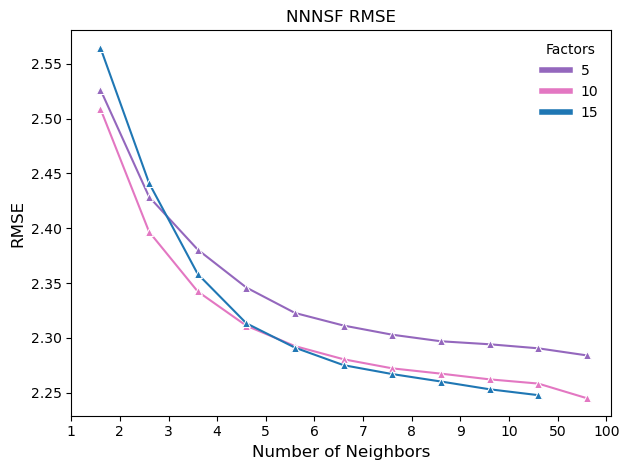

In [36]:
from matplotlib.lines import Line2D

ax = plt.axes() 

nnnsfh_df = nnnsf_k_experiments_df
x = np.arange(len(K))  # The x locations for the groups
width = 0.2  # The width of the bars

marker = {
    50: 'o',
    1000: 'X',
    2000: 's',
    2688: '^'
}

for i in range(len(nnnsfh_df.index) - 1, len(nnnsfh_df.index)):
    rmse = list(nnnsfh_df['5'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]], color='tab:purple', markersize=6)
    rmse = list(nnnsfh_df['10'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]], color='tab:pink', markersize=6)
    rmse = list(nnnsfh_df['15'])[i]
    sns.lineplot(x=x[:11] + i*width, y=rmse[:11], label=M[i], marker=marker[M[i]],  color='tab:blue', markersize=6)

#sns.barplot(data=nnnsfh_df)
#leg1_elem = [Line2D([0], [0], color='w', lw=4, label='50', marker='o', markerfacecolor='black'), 
            # Line2D([0], [0], color='w', lw=4, label='1000', marker='X', markerfacecolor='black'),
            #Line2D([0], [0], color='w', lw=4, label='2000', marker='s', markerfacecolor='black'),
           #Line2D([0], [0], color='w', lw=4, label='2688', marker='v', markerfacecolor='black')]
#leg1 = plt.legend(handles=leg1_elem, loc="right", title="IPs", frameon=False)
leg2_elem = [Line2D([0], [0], color='tab:purple', lw=4, label='5'), 
             Line2D([0], [0], color='tab:pink', lw=4, label='10'),
            Line2D([0], [0], color='tab:blue', lw=4, label='15')]
leg2 = plt.legend(handles=leg2_elem, loc="upper right", title="Factors", frameon=False)
#ax.add_artist(leg1)

ax.set_xticklabels(K)
ax.set_xticks([i for i in range(len(K)-2)])
ax.set_xlabel("Number of Neighbors", size=12)
ax.set_ylabel("RMSE", size=12)
ax.set_title("NNNSF RMSE")
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{FPATH}/visium_rmse_nnnsf_ips_and_factors_max_ips.png', bbox_inches='tight')
plt.show()

In [76]:
datapath = nnnsf_path
eval_function = mean_poisson_deviance
nnnsf_k_experiments_poi = calculate_eval_metric(X, Y, params, datapath, eval_function=eval_function, train=False, X_val=False, hybrid=False)

/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=1_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 1  neighbors:  2.319530520899511
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=2_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 2  neighbors:  2.100124656260443
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=3_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 3  neighbors:  2.0603516793902354
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=4_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  2.0276995086745533
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=5_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.01_bs=128_NMFinit_state_dict.pth
With 5 factors and 5  neighbors:  2.018568685150565
/engelhardt/h

In [77]:
nnnsf_k_experiments_df_poi = pd.DataFrame(nnnsf_k_experiments_poi)
nnnsf_k_experiments_df_poi.index = M 

In [78]:
#nnnsf_k_experiments_df_poi.to_csv(path.join(SPATH, 'visium_nnnsf_poi.csv'))
#nnnsf_k_experiments_df_poi = pd.read_csv(path.join(SPATH, 'visium_nnnsf_poi.csv'), index_col=0)

In [79]:
nnnsf_k_experiments_df_poi

5  \
50    [2.319530520899511, 2.100124656260443, 2.06035...   
1000  [2.534777634801163, 2.2029455192252283, 2.0788...   
2000  [2.5516601755538404, 2.243177890753303, 2.1240...   
2688  [2.5091686139724456, 2.258515570736764, 2.1459...   

                                                     10  \
50    [2.3365743525028364, 2.0593897857253154, 2.011...   
1000  [2.5393518050659174, 2.152342750665664, 2.0245...   
2000  [2.572618118915908, 2.205859831225, 2.06326163...   
2688  [2.5040016672482674, 2.2171484847549974, 2.085...   

                                                     15  
50    [2.46007306337426, 2.078091018403207, 2.032584...  
1000  [2.714367110252799, 2.2141233342314233, 2.0377...  
2000  [2.7622322787932894, 2.3101770998173463, 2.087...  
2688  [2.719546708970568, 2.3569387086993934, 2.1361...

In [95]:
df_col_5['5'].to_dict()

{50: [2.319530520899511,
  2.100124656260443,
  2.0603516793902354,
  2.0276995086745533,
  2.018568685150565,
  2.017905483508659,
  2.014452643418838,
  2.0103017748443057,
  2.0145000331849614,
  2.020647479306104,
  2.0212918998193294,
  1.9408658469701945],
 1000: [2.534777634801163,
  2.2029455192252283,
  2.078830349637125,
  2.014062372711705,
  1.9864903817385942,
  1.9688439917224292,
  1.9595699604998496,
  1.954763781125177,
  1.950057240649517,
  1.9488237623389941,
  1.942463074245513,
  1.8821096335542837],
 2000: [2.5516601755538404,
  2.243177890753303,
  2.124017478255105,
  2.049548087903604,
  2.009243215272924,
  1.9832621518937201,
  1.9698302075118435,
  1.9570269488547636,
  1.9528786067313424,
  1.9462069833285218,
  1.9334287731696622,
  1.863211440843778],
 2688: [2.5091686139724456,
  2.258515570736764,
  2.145960679684122,
  2.067619584407812,
  2.017224412416634,
  1.9921078905218272,
  1.9747691266155782,
  1.9629011287009213,
  1.9559892528936498,
  1.94

In [100]:
# Step 1: Split each column into its own DataFrame
df_col_5 = pd.DataFrame(nnnsf_k_experiments_df_poi['5'])
df_col_10 = pd.DataFrame(nnnsf_k_experiments_df_poi['10'])
df_col_15 = pd.DataFrame(nnnsf_k_experiments_df_poi['15'])

df_col_5_expanded = pd.DataFrame(df_col_5['5'].to_list())
df_col_10_expanded = pd.DataFrame(df_col_10['10'].to_list())
df_col_15_expanded = pd.DataFrame(df_col_15['15'].to_list())

In [105]:
rmse = list(nnnsfh_df['5'])[0]
print(rmse)

[2.319530520899511, 2.100124656260443, 2.0603516793902354, 2.0276995086745533, 2.018568685150565, 2.017905483508659, 2.014452643418838, 2.0103017748443057, 2.0145000331849614, 2.020647479306104, 2.0212918998193294, 1.9408658469701945]


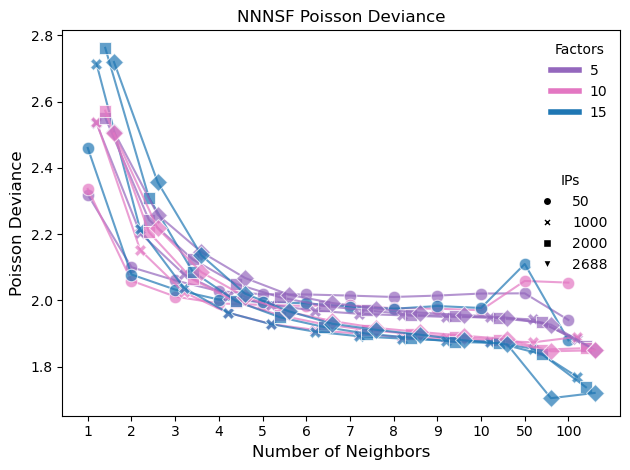

In [112]:
from matplotlib.lines import Line2D

ax = plt.axes() 

K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
nnnsfh_df = nnnsf_k_experiments_df_poi
x = np.arange(len(K))  # The x locations for the groups
width = 0.2  # The width of the bars

marker = {
    50: 'o',
    1000: 'X',
    2000: 's',
    2688: 'D'
}

#x = [i for i in range(len(K))]
for i in range(len(nnnsfh_df.index)):
    rmse = list(nnnsfh_df['5'])[i]
    sns.lineplot(x=x + i*width, y=rmse, label=M[i], marker=marker[M[i]], color='tab:purple', markersize=9, alpha=0.7)
    rmse = list(nnnsfh_df['10'])[i]
    sns.lineplot(x=x + i*width, y=rmse, label=M[i], marker=marker[M[i]], color='tab:pink', markersize=9, alpha=0.7)
    rmse = list(nnnsfh_df['15'])[i]
    sns.lineplot(x=x + i*width, y=rmse, label=M[i], marker=marker[M[i]], color='tab:blue', markersize=9, alpha=0.7)

leg1_elem = [Line2D([0], [0], color='w', lw=4, label='50', marker='o', markerfacecolor='black'), 
             Line2D([0], [0], color='w', lw=4, label='1000', marker='X', markerfacecolor='black'),
            Line2D([0], [0], color='w', lw=4, label='2000', marker='s', markerfacecolor='black'),
            Line2D([0], [0], color='w', lw=4, label='2688', marker='v', markerfacecolor='black')]

leg1 = plt.legend(handles=leg1_elem, loc="right", title="IPs", frameon=False)
leg2_elem = [Line2D([0], [0], color='tab:purple', lw=4, label='5'), 
             Line2D([0], [0], color='tab:pink', lw=4, label='10'),
            Line2D([0], [0], color='tab:blue', lw=4, label='15')]
leg2 = plt.legend(handles=leg2_elem, loc="upper right", title="Factors", frameon=False)
ax.add_artist(leg1)

ax.set_xticklabels(K)
ax.set_xticks([i for i in range(len(K))])
ax.set_xlabel("Number of Neighbors", size=12)
ax.set_ylabel("Poisson Deviance", size=12)
ax.set_title("NNNSF Poisson Deviance")
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
#plt.savefig(f'{FPATH}/visium_pd_nnnsf_ips_and_factors.png', bbox_inches='tight')
plt.show()

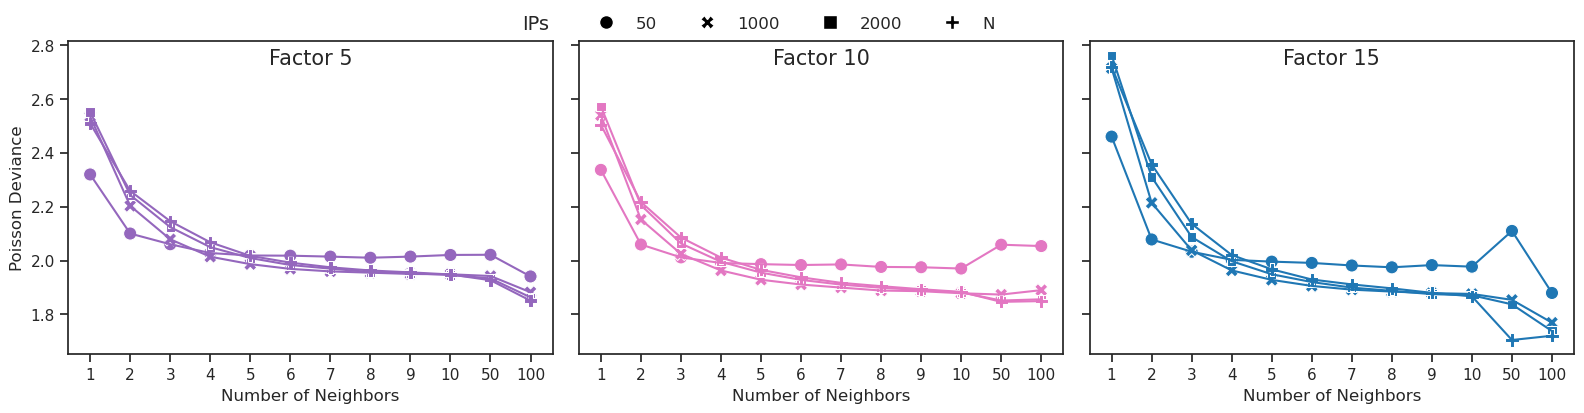

In [144]:
# Reshape the data into long-form (tidy format)
df_long5 = df_col_5_expanded.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='Poisson Deviance')
df_long10 = df_col_10_expanded.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='Poisson Deviance')
df_long15 = df_col_15_expanded.reset_index().melt(id_vars='index', var_name='Number of Neighbors', value_name='Poisson Deviance')

# Convert 'Number of Neighbors' to categorical for proper plotting
df_long5['Number of Neighbors'] = df_long5['Number of Neighbors'].astype(str)
df_long10['Number of Neighbors'] = df_long10['Number of Neighbors'].astype(str)
df_long15['Number of Neighbors'] = df_long15['Number of Neighbors'].astype(str)

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True)
sns.set_theme(style="ticks")

# Plot using seaborn with categorical x-axis
palette = ['tab:purple']
sns.lineplot(data=df_long5, x='Number of Neighbors', y='Poisson Deviance', hue='index', color='tab:purple', ci=None, ax=ax[0], palette=palette, legend=False)
sns.scatterplot(data=df_long5, x='Number of Neighbors', y='Poisson Deviance', style='index', color='tab:purple', ax=ax[0], legend=False, s=90)

palette = ['tab:pink']
sns.lineplot(data=df_long10, x='Number of Neighbors', y='Poisson Deviance', hue='index', color='tab:pink',  ci=None, ax=ax[1], palette=palette, legend=False)
sns.scatterplot(data=df_long10, x='Number of Neighbors', y='Poisson Deviance', style='index', color='tab:pink', ax=ax[1], legend=False, s=90)

palette = ['tab:blue']
sns.lineplot(data=df_long15, x='Number of Neighbors', y='Poisson Deviance', hue='index', color='tab:blue', ci=None, ax=ax[2], palette=palette, legend=False)
sns.scatterplot(data=df_long15, x='Number of Neighbors', y='Poisson Deviance', style='index', color='tab:blue', ax=ax[2], legend=False, s=90)

# Create custom legend using Line2D for the markers only
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='50', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='1000', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='2000', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='P', color='w', label='N', markerfacecolor='black', markersize=10),
]

# Add the custom legend outside the plot
#fig.legend(handles=legend_elements, loc="upper center", title="IPs", bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False, fontsize=14, title_fontsize=16)
fig.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False, fontsize=12)
fig.text(0.34, 0.98, "IPs", ha='center', fontsize=14) 

# Set labels for subplots
ax[0].set_title('Factor 5', fontsize=15, y=0.9)
ax[1].set_title('Factor 10', fontsize=15, y=0.9)
ax[2].set_title('Factor 15', fontsize=15, y=0.9)

ax[0].set_xticklabels(K)
ax[0].set_xticks([i for i in range(len(K))])

# Show plot
plt.tight_layout()
plt.savefig(f'{FPATH}/visium_poi_nnnsf_ips_and_factors_separated.png', bbox_inches='tight')
plt.show()

## Validation Figures

In [381]:
# Compare NMF, PNMF, NSF, NSFH, NNNSF, NNNSFH
# load NMF
nmf_pois = []
nmf_rmses = []
factors = [5, 10, 15]
for f in factors:
    factors_path = path.join(nmf_save_path, f"nmf_factors_iter=1000_rs=256_L={f}.npy")
    loadings_path = path.join(nmf_save_path, f"nmf_loadings_iter=1000_rs=256_L={f}.npy")
    loadings = np.load(loadings_path)
    factors = np.load(factors_path)
    nmf_model = NMF(n_components=f, max_iter=1000, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7).fit(Y)
    y_nmf = nmf_model.inverse_transform(nmf_model.transform(Y))
    not_strictly_positive_values = y_nmf[y_nmf <= 0]
    epsilon = 1e-10
    y_positive = y_nmf + epsilon
    nmf_rmse = average_rmse(Y, y_nmf.T)
    nmf_poi = mean_poisson_deviance(Y.flatten(), y_positive.flatten())
    nmf_pois.append(nmf_poi)
    nmf_rmses.append(nmf_rmse)
    print("Done with factor ", f)

Done with factor  5
Done with factor  10
Done with factor  15


In [382]:
# load pnmf
pnmf_pois = []
pnmf_rmses = []
factors = [5, 10, 15]
for f in factors:
    prior = GaussianPrior(Y, L=f)
    pnmf = PNMF(prior, Y, L=f)
    filepath = f"PNMF_L={f}_lr=0.1_iter=1000_state_dict.pth"
    datapath = path.join(SPATH, 'pnmf')
    dictpath = path.join(datapath, filepath)
    pnmf.load_state_dict(torch.load(dictpath))
    qF, pF = pnmf.prior()
    means = torch.exp(qF.mean).detach().numpy()
    W = pnmf.W
    W_transformed = nn.functional.softplus(W.T)
    W_transformed = W_transformed.detach().numpy()
    y_pnmf = ((means.T)).dot(W_transformed)
    pnmf_rmse = average_rmse(Y, y_pnmf)
    pnmf_poi = mean_poisson_deviance(Y.flatten(), y_pnmf.T.flatten())
    pnmf_rmses.append(pnmf_rmse)
    pnmf_pois.append(pnmf_poi)
    print("Done with factor ", f)

Done with factor  5
Done with factor  10
Done with factor  15


In [14]:
# load NSF
params = {
    'L' : [5, 10, 15],
    'M' : [50, 1000, 2000, len(X_train)],
    'model': 'SVGP',
    'jtr': 0.001,
    'lengthscale': 1.0,
    'sigma': 1.0,
    'L1_jitter':0.01,
    'lr': 0.001,
}

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, Y.T, test_size=0.05, random_state=256)
datapath = path.join(nsf_path, 'validation_experiments')
print(datapath)
eval_function = mean_poisson_deviance
nsf_k_experiments = calculate_eval_metric_nsf(X_train, y_train.T, params, datapath, eval_function=eval_function, train=True, X_val=X_val, hybrid=False)

/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=50_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 50  IPs:  (1.9153482057292954, 1.983549411214254)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=1000_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 1000  IPs:  (1.8760494177444187, 1.9215627392569108)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=2000_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 2000  IPs:  (1.8700358382800222, 1.9273373795452224)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=2553_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma

In [16]:
nsf_pois_df = pd.DataFrame(nsf_k_experiments)
#nsfh_pois_df = pd.DataFrame(nsfh_k_experiments)

In [18]:
SPATH

'/engelhardt/home/pshrestha/vnngp/results/visium/'

In [20]:
nsf_pois_df.to_csv(path.join(SPATH, "nsf_poi.csv"))

In [417]:
# load NNNSF
params = {
    'L' : [5, 10, 15],
    'K' : [4],
    'M' : [50, 1000, 2000, len(X_train)],
    'model': 'VNNGP',
    'jtr': 0.1,
    'lengthscale': 1.0,
    'sigma': 1.0,
    'L1_jitter':0.1,
    'lr': 0.001,
}

In [420]:
datapath = nnnsf_path
datapath = path.join(nnnsf_path, 'validation_experiments')
eval_function = mean_poisson_deviance
nnnsf_k_experiments = calculate_eval_metric(X, Y, params, datapath, eval_function=eval_function, train=True, X_val=X_val, hybrid=False)

Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (1.912240356815144, 1.968252933428606)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=1000_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (1.8348435087828692, 1.914941860438581)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=2000_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (1.8278671224404675, 1.8973840235767405)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=2553_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMF

In [421]:
nnnsf_pois_df = pd.DataFrame(nnnsf_k_experiments)

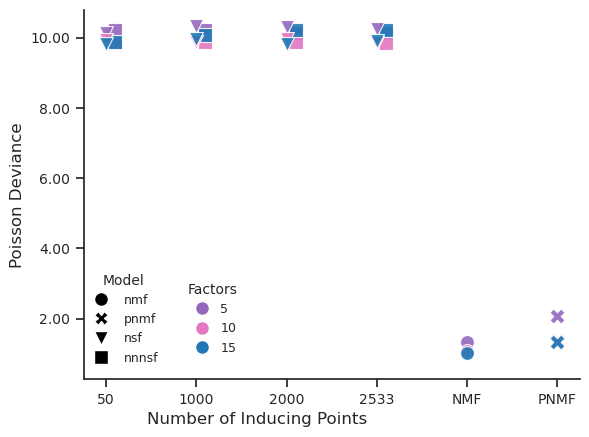

In [462]:
# Initialize the plot
ax = plt.axes() 

# Define labels
L = [5, 10, 15]

# Scatter plots for NMF and PNMF (without offsets)
sns.scatterplot(x=[4], y=[nmf_pois[0]], color='tab:purple', s=100, alpha=0.9)
sns.scatterplot(x=[4], y=[nmf_pois[1]], color='tab:pink', s=100, alpha=0.9)
sns.scatterplot(x=[4], y=[nmf_pois[2]], color='tab:blue', s=100, alpha=0.9)

sns.scatterplot(x=[5], y=[pnmf_pois[0]], color='tab:purple', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[5], y=[pnmf_pois[1]], color='tab:pink', s=120, marker='X', alpha=0.9)
sns.scatterplot(x=[5], y=[pnmf_pois[2]], color='tab:blue', s=120, marker='X', alpha=0.9)

# Collect data for nnnsf_pois_df with offset
five_nnnsf = [nnnsf_pois_df['5'][i][0][0] for i in nnnsf_pois_df.index]
ten_nnnsf = [nnnsf_pois_df['10'][i][0][0] for i in nnnsf_pois_df.index]
ff_nnnsf = [nnnsf_pois_df['15'][i][0][0] for i in nnnsf_pois_df.index]

# Scatter plots for NNNSF with x-axis offset by 0.1
sns.scatterplot(x=[i + 0.1 for i in range(len(five_nnnsf))], y=five_nnnsf, label=L[0], color='tab:purple', s=100, marker='s', alpha=0.9)
sns.scatterplot(x=[i + 0.1 for i in range(len(ten_nnnsf))], y=ten_nnnsf, label=L[1], color='tab:pink', s=100, marker='s', alpha=0.9)
sns.scatterplot(x=[i + 0.1 for i in range(len(ff_nnnsf))], y=ff_nnnsf, label=L[2], color='tab:blue', s=100, marker='s', alpha=0.9)

#five = [list(nnnsfh_k_experiments_df_poi['5'])[i][3][0] for i in nnnsf_pois_df.index]
#ten = [list(nnnsfh_k_experiments_df_poi['10'])[i][3][0] for i in nnnsf_pois_df.index]
#ff = [list(nnnsfh_k_experiments_df_poi['15'])[i][3][0] for i in nnnsf_pois_df.index]

#sns.scatterplot(x=[i + 0.10 for i in range(len(five))], y=five, label=L[0], color='tab:purple', s=80, marker='*')
#sns.scatterplot(x=[i + 0.10 for i in range(len(ten))], y=ten, label=L[1],color='tab:pink', s=80,  marker='*')
#sns.scatterplot(x=[i + 0.10 for i in range(len(ff))], y=ff, label=L[2], color='tab:blue', s=80,  marker='*')


# Collect data for nsf_pois_df
five_nsf = [nsf_pois_df['5'][i][0] for i in nsf_pois_df.index]
ten_nsf = [nsf_pois_df['10'][i][0] for i in nsf_pois_df.index]
ff_nsf = [nsf_pois_df['15'][i][0] for i in nsf_pois_df.index]

# Scatter plots for NSF
sns.scatterplot(x=[i for i in range(len(five_nsf))], y=five_nsf, label=L[0], color='tab:purple', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ten_nsf))], y=ten_nsf, label=L[1], color='tab:pink', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ff_nsf))], y=ff_nsf, label=L[2], color='tab:blue', s=100, marker='v', alpha=0.9)

sns.scatterplot(x=[3.5], y=[0.75], color='w', zorder=5, s=200, marker='s')

# Configure axes
ax.set_xticks([i for i in range(6)])
ax.set_xticklabels(['50', '1000', '2000', '2533', 'NMF', 'PNMF'], fontsize=10)
ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=10)

# Legends
leg1_elem = [
    Line2D([0], [0], color='w', lw=4, label='nmf', marker='o', markerfacecolor='black', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='pnmf', marker='X', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nsf', marker='v', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nnnsf', marker='s', markerfacecolor='black', markersize=10)
]
leg1 = plt.legend(
    handles=leg1_elem, 
    bbox_to_anchor=(0, 0.3), 
    loc="upper left", 
    title="Model", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
   
)

leg2_elem = [
    Line2D([0], [0], color='w', lw=4, label='5', marker='o', markerfacecolor='tab:purple', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='10', marker='o', markerfacecolor='tab:pink', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='15', marker='o', markerfacecolor='tab:blue', markersize=10)
]
leg2 = plt.legend(
    handles=leg2_elem, 
    bbox_to_anchor=(0.20, 0.275), 
    loc="upper left", 
    title="Factors", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
    handletextpad=0.5
)


# Add legends and labels
ax.add_artist(leg1)
#ax.set_ylim(0.75, 2.2)
ax.set_xlabel("Number of Inducing Points", size=12, x=0.35)
ax.set_ylabel("Poisson Deviance", size=12)
#ax.set_title("Model Goodness of Fit Comparison")
sns.despine()
# Show the plot
plt.savefig(f'{SPATH}/visium_goodness_of_fit_without_hybrid_models.png', bbox_inches='tight')
plt.show()

In [441]:
# load NSF
params = {
    'L' : [5, 10, 15],
    'M' : [50, 1000, 2000, len(X_train)],
    'model': 'SVGP',
    'jtr': 0.001,
    'lengthscale': 1.0,
    'sigma': 1.0,
    'L1_jitter':0.01,
    'lr': 0.001,
}
datapath = path.join(nsf_path, 'validation_experiments')
eval_function = root_mean_squared_error
nsf_k_experiments = calculate_eval_metric_nsf(X_train, y_train.T, params, datapath, eval_function=eval_function, train=True, X_val=X_val, hybrid=False)

Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=50_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 50  IPs:  (10.14203336874363, 10.321181434464206)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=1000_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 1000  IPs:  (10.314938366392441, 10.5930285840763)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=2000_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 2000  IPs:  (10.303822808260398, 10.362998091871889)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nsf/validation_experiments/SVGP_M=2553_L=5_lr=0.001_jtr=0.001_ls=1.0_sigma=1.0_bs=64_NMFinit_state_dict.pth
With 5 factors and 2553  IPs:  (10.25628899

In [442]:
# load NNNSF
params = {
    'L' : [5, 10, 15],
    'K' : [4],
    'M' : [50, 1000, 2000, len(X_train)],
    'model': 'VNNGP',
    'jtr': 0.1,
    'lengthscale': 1.0,
    'sigma': 1.0,
    'L1_jitter':0.1,
    'lr': 0.001,
}
datapath = nnnsf_path
datapath = path.join(nnnsf_path, 'validation_experiments')
eval_function = root_mean_squared_error
nnnsf_k_experiments = calculate_eval_metric(X, Y, params, datapath, eval_function=eval_function, train=True, X_val=X_val, hybrid=False)

Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=50_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (10.218211496509044, 10.433275080579756)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=1000_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (10.20716697730848, 10.495123148922739)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=2000_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth
With 5 factors and 4  neighbors:  (10.121588715622602, 10.406698009249817)
Loading model on training data
/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/validation_experiments/VNNGP_K=4_lkzz=1_M=2553_L=5_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_N

In [443]:
nsf_rmse_df = pd.DataFrame(nsf_k_experiments)
nnnsf_rmse_df = pd.DataFrame(nnnsf_k_experiments)

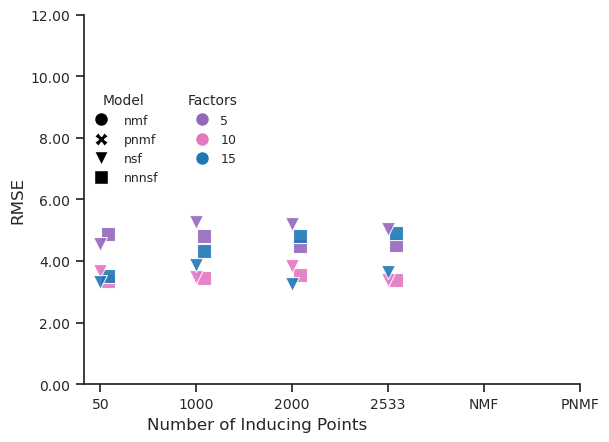

In [461]:
# Initialize the plot
ax = plt.axes() 

# Define labels
L = [5, 10, 15]

# Scatter plots for NMF and PNMF (without offsets)
#sns.scatterplot(x=[4], y=[nmf_rmses[0]], color='tab:purple', s=100, alpha=0.9)
#sns.scatterplot(x=[4], y=[nmf_rmses[1]], color='tab:pink', s=100, alpha=0.9)
#sns.scatterplot(x=[4], y=[nmf_rmses[2]], color='tab:blue', s=100, alpha=0.9)

#sns.scatterplot(x=[5], y=[pnmf_rmses[0]], color='tab:purple', s=120, marker='X', alpha=0.9)
#sns.scatterplot(x=[5], y=[pnmf_rmses[1]], color='tab:pink', s=120, marker='X', alpha=0.9)
#sns.scatterplot(x=[5], y=[pnmf_rmses[2]], color='tab:blue', s=120, marker='X', alpha=0.9)

nnnsf_pois_df = nnnsf_rmse_df
nsf_pois_df = nsf_rmse_df

# Collect data for nnnsf_pois_df with offset
five_nnnsf = [nnnsf_pois_df['5'][i][0][0] for i in nnnsf_pois_df.index]
ten_nnnsf = [nnnsf_pois_df['10'][i][0][0] for i in nnnsf_pois_df.index]
ff_nnnsf = [nnnsf_pois_df['15'][i][0][0] for i in nnnsf_pois_df.index]

# Scatter plots for NNNSF with x-axis offset by 0.1
sns.scatterplot(x=[i + 0.08 for i in range(len(five_nnnsf))], y=five_nnnsf, label=L[0], color='tab:purple', s=100, marker='s', alpha=0.9)
sns.scatterplot(x=[i + 0.08 for i in range(len(ten_nnnsf))], y=ten_nnnsf, label=L[1], color='tab:pink', s=100, marker='s', alpha=0.9)
sns.scatterplot(x=[i + 0.08 for i in range(len(ff_nnnsf))], y=ff_nnnsf, label=L[2], color='tab:blue', s=100, marker='s', alpha=0.9)

#five = [list(nnnsfh_k_experiments_df_poi['5'])[i][3][0] for i in nnnsf_pois_df.index]
#ten = [list(nnnsfh_k_experiments_df_poi['10'])[i][3][0] for i in nnnsf_pois_df.index]
#ff = [list(nnnsfh_k_experiments_df_poi['15'])[i][3][0] for i in nnnsf_pois_df.index]

#sns.scatterplot(x=[i + 0.10 for i in range(len(five))], y=five, label=L[0], color='tab:purple', s=80, marker='*')
#sns.scatterplot(x=[i + 0.10 for i in range(len(ten))], y=ten, label=L[1],color='tab:pink', s=80,  marker='*')
#sns.scatterplot(x=[i + 0.10 for i in range(len(ff))], y=ff, label=L[2], color='tab:blue', s=80,  marker='*')


# Collect data for nsf_pois_df
five_nsf = [nsf_pois_df['5'][i][0] for i in nsf_pois_df.index]
ten_nsf = [nsf_pois_df['10'][i][0] for i in nsf_pois_df.index]
ff_nsf = [nsf_pois_df['15'][i][0] for i in nsf_pois_df.index]

# Scatter plots for NSF
sns.scatterplot(x=[i for i in range(len(five_nsf))], y=five_nsf, label=L[0], color='tab:purple', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ten_nsf))], y=ten_nsf, label=L[1], color='tab:pink', s=100, marker='v', alpha=0.9)
sns.scatterplot(x=[i for i in range(len(ff_nsf))], y=ff_nsf, label=L[2], color='tab:blue', s=100, marker='v', alpha=0.9)

sns.scatterplot(x=[3.5], y=[0.75], color='w', zorder=5, s=200, marker='s')

# Configure axes
ax.set_xticks([i for i in range(6)])
ax.set_xticklabels(['50', '1000', '2000', '2533', 'NMF', 'PNMF'], fontsize=10)
ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=10)

# Legends
leg1_elem = [
    Line2D([0], [0], color='w', lw=4, label='nmf', marker='o', markerfacecolor='black', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='pnmf', marker='X', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nsf', marker='v', markerfacecolor='black', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='nnnsf', marker='s', markerfacecolor='black', markersize=10)
]
leg1 = plt.legend(
    handles=leg1_elem, 
    bbox_to_anchor=(0, 0.8), 
    loc="upper left", 
    title="Model", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
   
)

leg2_elem = [
    Line2D([0], [0], color='w', lw=4, label='5', marker='o', markerfacecolor='tab:purple', markersize=10), 
    Line2D([0], [0], color='w', lw=4, label='10', marker='o', markerfacecolor='tab:pink', markersize=10),
    Line2D([0], [0], color='w', lw=4, label='15', marker='o', markerfacecolor='tab:blue', markersize=10)
]
leg2 = plt.legend(
    handles=leg2_elem, 
    bbox_to_anchor=(0.20, 0.8), 
    loc="upper left", 
    title="Factors", 
    fontsize=9, 
    frameon=False, 
    title_fontsize='10',
    borderaxespad=0.,
    handletextpad=0.5
)


# Add legends and labels
ax.add_artist(leg1)
ax.set_ylim(9, 12)
ax.set_xlabel("Number of Inducing Points", size=12, x=0.35)
ax.set_ylabel("RMSE", size=12)
#ax.set_title("Model Goodness of Fit Comparison")
sns.despine()
# Show the plot
plt.savefig(f'{SPATH}/visium_goodness_of_fit_without_hybrid_models_rmse.png', bbox_inches='tight')
plt.show()

## Patches Validation

In [12]:
nnnsf_path = path.join(nnnsf_path, 'patches_experiments')

In [13]:
mean_ks_poi5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_poi_fov=470.npy'))
mean_ks_rmse5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_rmse_fov=470.npy'))

mean_ks_poi10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_poi_fov=470.npy'))
mean_ks_rmse10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_rmse_fov=470.npy'))

mean_ks_poi15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_poi_fov=470.npy'))
mean_ks_rmse15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_rmse_fov=470.npy'))

In [14]:
len(mean_ks_poi5)
len(mean_ks_poi10)
len(mean_ks_poi15)

14

In [15]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200, 300]

In [16]:
len(K)

15

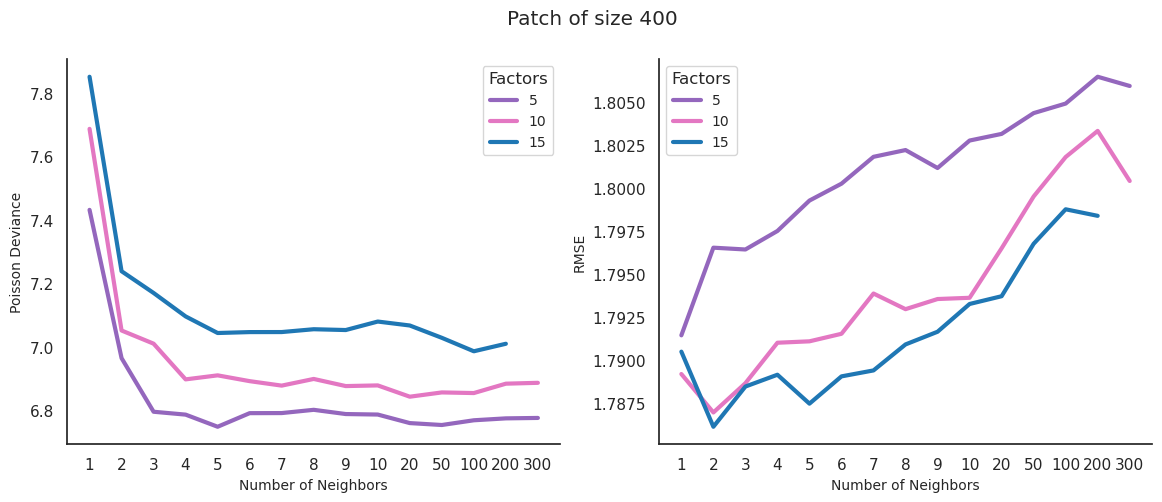

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
sns.set_theme(style="white")
sns.lineplot(mean_ks_poi5[:15], label='5', linewidth=3, color='tab:purple', ax=ax[0])
sns.lineplot(mean_ks_poi10[:15], label='10', linewidth=3, color='tab:pink', ax=ax[0])
sns.lineplot(mean_ks_poi15[:15], label='15', linewidth=3, color='tab:blue', ax=ax[0])
ax[0].legend(title="Factors", fontsize=10)
ax[0].set_xticks([i for i in range(len(K))])
ax[0].set_xticklabels(K)
ax[0].set_xlabel("Number of Neighbors", size=10,)
ax[0].set_ylabel("Poisson Deviance", size=10)

sns.lineplot(mean_ks_rmse5[:15], linewidth=3, label='5', color='tab:purple', ax=ax[1])
sns.lineplot(mean_ks_rmse10[:15],linewidth=3, label='10',  color='tab:pink', ax=ax[1])
sns.lineplot(mean_ks_rmse15[:15], linewidth=3, label='15', color='tab:blue', ax=ax[1])
ax[1].legend(title="Factors", fontsize=10)
ax[1].legend(title="Factors", fontsize=10)
ax[1].set_xticks([i for i in range(len(K))])
ax[1].set_xticklabels(K)
ax[1].set_xlabel("Number of Neighbors", size=10,)
ax[1].set_ylabel("RMSE", size=10)
fig.suptitle("Patch of size 400")
sns.despine()
plt.savefig(path.join(FPATH, 'kexp_path=400.png'))

In [21]:
mean_ks_poi5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_poi_fov=100.npy'))
mean_ks_rmse5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_rmse_fov=100.npy'))

mean_ks_poi10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_poi_fov=100.npy'))
mean_ks_rmse10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_rmse_fov=100.npy'))

mean_ks_poi15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_poi_fov=100.npy'))
mean_ks_rmse15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_rmse_fov=100.npy'))

In [31]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
sns.set_theme(style="white")
sns.lineplot(mean_ks_poi5[:15], label='5', linewidth=3, color='tab:purple', ax=ax[0])
sns.lineplot(mean_ks_poi10[:15], label='10', linewidth=3, color='tab:pink', ax=ax[0])
sns.lineplot(mean_ks_poi15[:15], label='15', linewidth=3, color='tab:blue', ax=ax[0])
ax[0].legend(title="Factors", fontsize=10)
ax[0].set_xticks([i for i in range(len(K))])
ax[0].set_xticklabels(K)
ax[0].set_xlabel("Number of Neighbors", size=10,)
ax[0].set_ylabel("Poisson Deviance", size=10)

sns.lineplot(mean_ks_rmse5[:15], linewidth=3, label='5', color='tab:purple', ax=ax[1])
sns.lineplot(mean_ks_rmse10[:15],linewidth=3, label='10',  color='tab:pink', ax=ax[1])
sns.lineplot(mean_ks_rmse15[:15], linewidth=3, label='15', color='tab:blue', ax=ax[1])
ax[1].legend(title="Factors", fontsize=10)
ax[1].legend(title="Factors", fontsize=10)
ax[1].set_xticks([i for i in range(len(K))])
ax[1].set_xticklabels(K)
ax[1].set_xlabel("Number of Neighbors", size=10,)
ax[1].set_ylabel("RMSE", size=10)
fig.suptitle("Patch of size 100")
sns.despine()
plt.savefig(path.join(FPATH, 'kexp_path=100.png'))

In [32]:
mean_ks_poi5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_poi_fov=104.npy'))
mean_ks_rmse5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_rmse_fov=104.npy'))

mean_ks_poi10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_poi_fov=104.npy'))
mean_ks_rmse10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_rmse_fov=104.npy'))

mean_ks_poi15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_poi_fov=104.npy'))
mean_ks_rmse15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_rmse_fov=104.npy'))

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
sns.set_theme(style="whitegrid")
sns.lineplot(mean_ks_poi5[:15], label='5', linewidth=3, color='tab:purple', ax=ax[0])
sns.lineplot(mean_ks_poi10[:15], label='10', linewidth=3, color='tab:pink', ax=ax[0])
sns.lineplot(mean_ks_poi15[:15], label='15', linewidth=3, color='tab:blue', ax=ax[0])
ax[0].legend(title="Factors", fontsize=10)
ax[0].set_xticks([i for i in range(len(K))])
ax[0].set_xticklabels(K)
ax[0].set_xlabel("Number of Neighbors", size=10,)
ax[0].set_ylabel("Poisson Deviance", size=10)

sns.lineplot(mean_ks_rmse5[:15], linewidth=3, label='5', color='tab:purple', ax=ax[1])
sns.lineplot(mean_ks_rmse10[:15],linewidth=3, label='10',  color='tab:pink', ax=ax[1])
sns.lineplot(mean_ks_rmse15[:15], linewidth=3, label='15', color='tab:blue', ax=ax[1])
ax[1].legend(title="Factors", fontsize=10)
ax[1].legend(title="Factors", fontsize=10)
ax[1].set_xticks([i for i in range(len(K))])
ax[1].set_xticklabels(K)
ax[1].set_xlabel("Number of Neighbors", size=10,)
ax[1].set_ylabel("RMSE", size=10)
#ax[0].set_ylim(7.4, 8.5)
fig.suptitle("Patch of size 104")
sns.despine()
plt.savefig(path.join(FPATH, 'kexp_path=104.png'))

In [33]:
mean_ks_poi5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_poi_fov=104_cortex.npy'))
mean_ks_rmse5 = np.load(path.join(nnnsf_path, 'k_exp_L=5_rmse_fov=104_cortex.npy'))

mean_ks_poi10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_poi_fov=104_cortex.npy'))
mean_ks_rmse10 = np.load(path.join(nnnsf_path, 'k_exp_L=10_rmse_fov=104_cortex.npy'))

mean_ks_poi15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_poi_fov=104_cortex.npy'))
mean_ks_rmse15 = np.load(path.join(nnnsf_path, 'k_exp_L=15_rmse_fov=104_cortex.npy'))

In [34]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 70, 100, 104]
fig, ax = plt.subplots(1,2, figsize=(14, 5))
sns.set_theme(style="white")
sns.lineplot(mean_ks_poi5[:15], label='5', linewidth=3, color='tab:purple', ax=ax[0])
sns.lineplot(mean_ks_poi10[:15], label='10', linewidth=3, color='tab:pink', ax=ax[0])
sns.lineplot(mean_ks_poi15[:15], label='15', linewidth=3, color='tab:blue', ax=ax[0])
ax[0].legend(title="Factors", fontsize=10)
ax[0].set_xticks([i for i in range(len(K))])
ax[0].set_xticklabels(K)
ax[0].set_xlabel("Number of Neighbors", size=10,)
ax[0].set_ylabel("Poisson Deviance", size=10)

sns.lineplot(mean_ks_rmse5[:15], linewidth=3, label='5', color='tab:purple', ax=ax[1])
sns.lineplot(mean_ks_rmse10[:15],linewidth=3, label='10',  color='tab:pink', ax=ax[1])
sns.lineplot(mean_ks_rmse15[:15], linewidth=3, label='15', color='tab:blue', ax=ax[1])
ax[1].legend(title="Factors", fontsize=10)
ax[1].legend(title="Factors", fontsize=10)
ax[1].set_xticks([i for i in range(len(K))])
ax[1].set_xticklabels(K)
ax[1].set_xlabel("Number of Neighbors", size=10,)
ax[1].set_ylabel("RMSE", size=10)
#ax[0].set_ylim(7.4, 8.5)
fig.suptitle("Patch of size 104 Cortex")
sns.despine()
plt.savefig(path.join(FPATH, 'kexp_path=100_cortex_both.png'))

In [36]:
fig, ax = plt.subplots()
sns.set_theme(style="white")
sns.lineplot(mean_ks_poi5[:15], label='5', color='tab:purple', linewidth=3)
sns.lineplot(mean_ks_poi10[:15], label='10', color='tab:pink', linewidth=3)
sns.lineplot(mean_ks_poi15[:15], label='15', color='tab:blue', linewidth=3)
ax.legend(title="Factors", fontsize=10, frameon=False)
ax.set_xticks([i for i in range(len(K))])
ax.set_xticklabels(K)
ax.set_xlabel("Number of Neighbors", size=10,)
ax.set_ylabel("Poisson Deviance", size=10)
sns.despine()
plt.savefig(path.join(FPATH, 'kexp_path=104_cortex.png'))

In [177]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 104]
test = pd.DataFrame({1: mean_ks_poi5[:14], 2: mean_ks_poi10[:14], 3: mean_ks_poi15[:14]}, index=K)
test.to_csv(path.join(SPATH, 'kexp_path=104_cortex_poi.csv'))

## Biological Analysis

In [8]:
adata = sq.datasets.visium_hne_adata()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
    
Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = adata.obsm['spatial']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

In [9]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

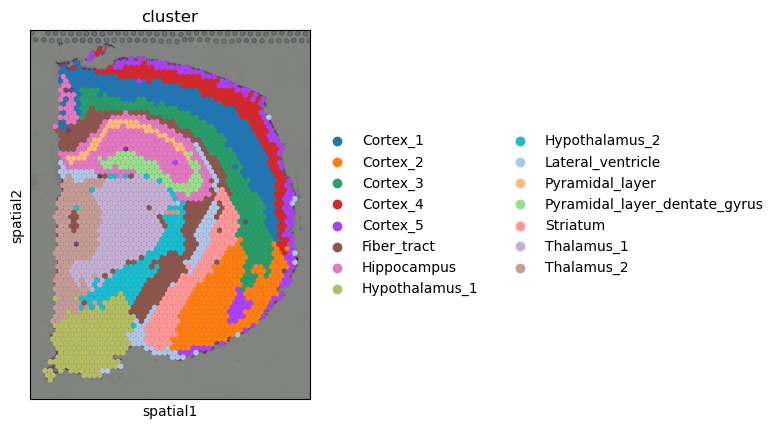

In [10]:
#sc.pl.umap(adata, color=['cluster'], size=20)
#sc.pl.pca(adata, color=['cluster'])
sc.pl.spatial(adata, color='cluster', spot_size=150)

In [11]:
dicts = {
            'L': 10, 
            'M': len(X_train), 
            'K': 8,
            'sigma': 1.0, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

NNNSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
putil.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']

file_path = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

X = torch.tensor(X).type(torch.float)
rmse = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=root_mean_squared_error,
                                  kwargs=dicts)
poid = putil.evaluate_model(NNNSF, X, Y.T, device, evaluation_metric=mean_poisson_deviance,
                                  kwargs=dicts)

print("Iterations: ", len(nnnsf_model_dict['losses']))
print("Runtime: ", (nnnsf_model_dict['time']))
print("RMSE: ", rmse)
print("Poisson Deviance: ", poid)

NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors

Iterations:  5000
Runtime:  326.2285270690918
RMSE:  2.181823170368393
Poisson Deviance:  1.7111182390454285


(<Figure size 750x300 with 10 Axes>,
 array([[<Axes: title={'center': 'Slc37a2'}>,
         <Axes: title={'center': 'Muc3a'}>,
         <Axes: title={'center': 'Gm14002'}>,
         <Axes: title={'center': 'Hfm1'}>,
         <Axes: title={'center': 'Lzts3'}>],
        [<Axes: title={'center': 'Shank1'}>,
         <Axes: title={'center': 'Slc26a6'}>,
         <Axes: title={'center': 'Fam20b'}>,
         <Axes: title={'center': 'Stk32b'}>,
         <Axes: title={'center': 'Fbxl3'}>]], dtype=object))

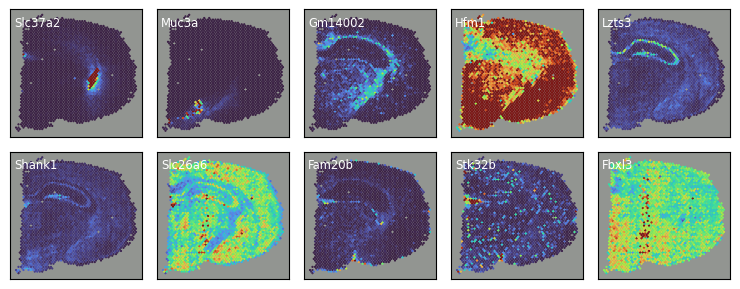

In [12]:
moran_idx, moranI = putil.dims_autocorr(factors, np.array(X_train))
factors = factors[:, moran_idx]
loadings = loadings[:, moran_idx]
loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
names = adata.var.index[loadings_softmax.argmax(axis=0)]
putil.plot_factors(Y[loadings_softmax.argmax(axis=0)], np.array(X), size=1.5, s=0.3, alpha=1, names=names)

In [61]:
def plot_top_genes(factors, loadings, X, y, num_genes= 5, size=2, alpha=0.8, s=0.1, names=None):

    max_val_factors = np.percentile(factors, 99)
    min_val_factors = np.percentile(factors, 1)

    L = len(factors)


    loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)

    order = torch.argsort(loadings_softmax, dim=0, descending=True)

    y_top = y[order[:num_genes]]
    fig, ax = plt.subplots(L, num_genes+1, figsize=(size*(num_genes+1), size*L), tight_layout=True)

    for i in range(L):
        

        curr_ax = ax[i, 0]
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val_factors, vmax=max_val_factors, alpha=alpha, cmap='turbo', s=s)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

        names = adata.var.index[order[:num_genes, i]]


        for j in range(num_genes):
            
            curr_ax = ax[i, j+1]
            curr_ax.scatter(X[:, 0], X[:,1], c=y_top[j, i], alpha=alpha, cmap='turbo', s=s)
            curr_ax.invert_yaxis()
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            curr_ax.set_facecolor('xkcd:gray')

            curr_ax.set_title(names[j], x=0.03, y=.88, fontsize="small", c="white",
                         ha="left", va="top", fontweight="bold")
    return fig

def get_top_genes(factors, loadings, y, adata, num_factors=5, num_genes=5):
    """
    Extracts the top genes for the top spatially correlated factors.
    
    Args:
        factors (np.ndarray): Array of factors (e.g., PCA, NMF, etc.).
        loadings (torch.Tensor): Loadings matrix (e.g., factor loadings).
        adata (AnnData): AnnData object containing gene names in `var`.
        num_factors (int): Number of top spatially correlated factors to extract.
        num_genes (int): Number of top genes to extract for each factor.
    
    Returns:
        dict: Dictionary with factor indices as keys and corresponding top gene names as values.
    """

    loadings_softmax = torch.nn.functional.softmax(torch.tensor(loadings), dim=1)
    order = torch.argsort(loadings_softmax, dim=0, descending=True)
    genes = {}
    for i in range(num_factors):
        names = list(adata.var.index[order[:num_genes, i]])
        genes[i] = names
    return genes

def normalize_rows(loadings):
    """
    Normalize rows of the loadings matrix such that each row sums to 1.

    Parameters:
        loadings (numpy.ndarray): A 2D array of shape (n_genes, n_components).

    Returns:
        numpy.ndarray: The normalized loadings matrix.
    """
    # Compute row sums
    row_sums = loadings.sum(axis=1, keepdims=True)
    
    # Avoid division by zero (if a row sum is zero, leave the row unchanged)
    row_sums[row_sums == 0] = 1
    
    # Normalize each row
    normalized_loadings = loadings / row_sums
    
    return normalized_loadings

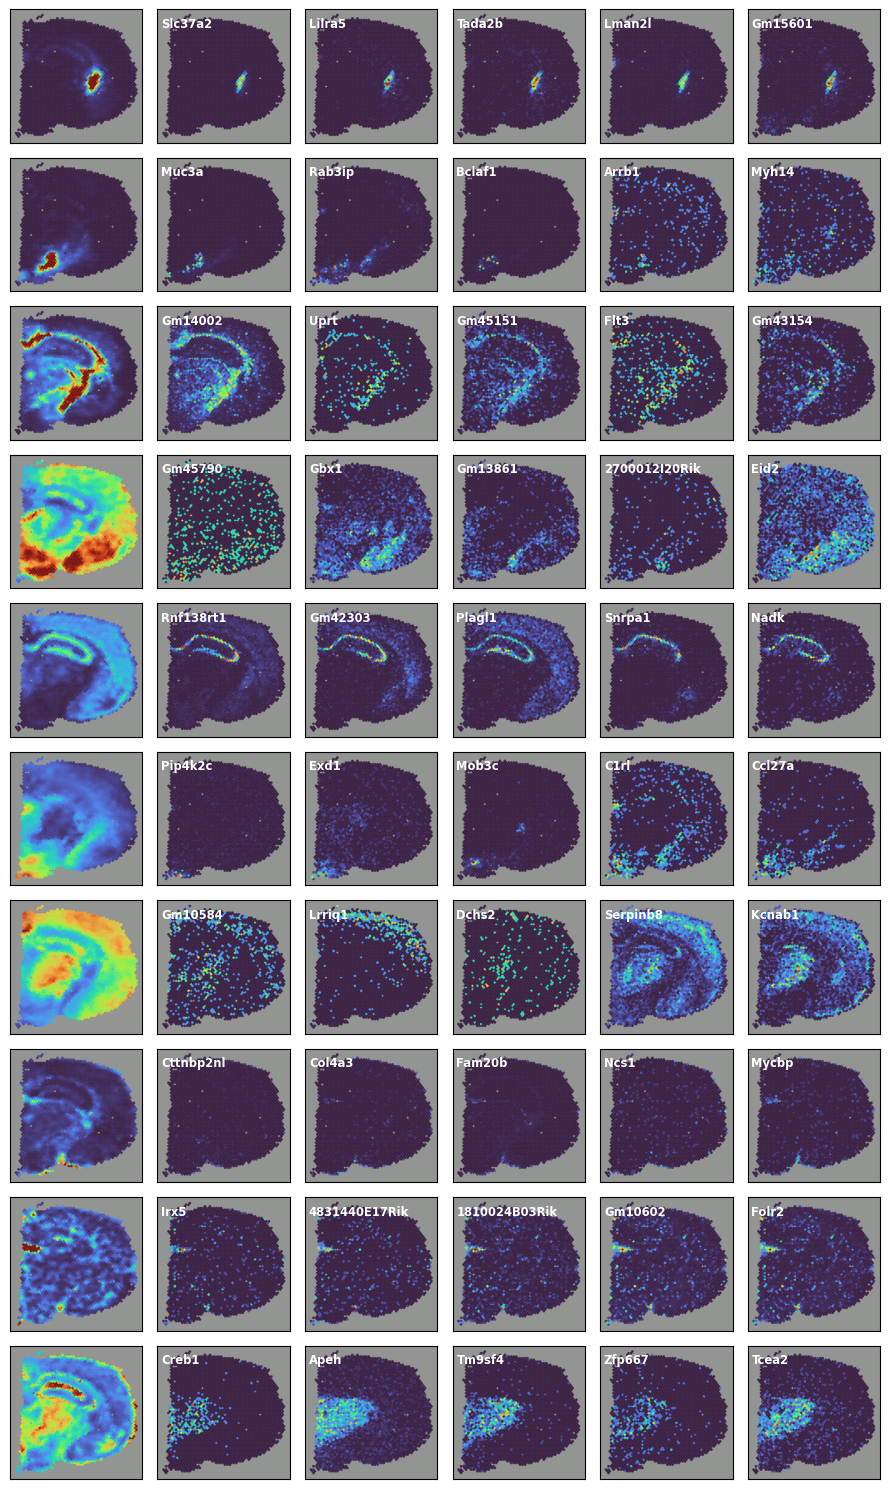

In [87]:
W = torch.nn.functional.softplus(NNNSF.W)
fig = plot_top_genes(means, loadings_normalized, X, Y, num_genes=5, size=1.5, alpha=0.7, s=1.0)
fig.savefig(f"{FPATH}/nnnsf_l={dicts['L']}_m={dicts['M']}_k={dicts['K']}_5genes.png")
fig.show()

In [88]:
loadings_normalized = normalize_rows(W)

In [89]:
top_genes = get_top_genes(factors, loadings_normalized, Y, adata, num_factors=10, num_genes=5)

In [90]:
top_genes

{0: ['Slc37a2', 'Lilra5', 'Tada2b', 'Lman2l', 'Gm15601'],
 1: ['Muc3a', 'Rab3ip', 'Bclaf1', 'Arrb1', 'Myh14'],
 2: ['Gm14002', 'Uprt', 'Gm45151', 'Flt3', 'Gm43154'],
 3: ['Gm45790', 'Gbx1', 'Gm13861', '2700012I20Rik', 'Eid2'],
 4: ['Rnf138rt1', 'Gm42303', 'Plagl1', 'Snrpa1', 'Nadk'],
 5: ['Pip4k2c', 'Exd1', 'Mob3c', 'C1rl', 'Ccl27a'],
 6: ['Gm10584', 'Lrriq1', 'Dchs2', 'Serpinb8', 'Kcnab1'],
 7: ['Cttnbp2nl', 'Col4a3', 'Fam20b', 'Ncs1', 'Mycbp'],
 8: ['Irx5', '4831440E17Rik', '1810024B03Rik', 'Gm10602', 'Folr2'],
 9: ['Creb1', 'Apeh', 'Tm9sf4', 'Zfp667', 'Tcea2']}

In [95]:
enrichment_results = {}
for factor_idx, genes in top_genes.items():
    print(f"Running GO enrichment for Factor {factor_idx}...")
    enr = gps.enrichr(gene_list=genes, gene_sets=['GO_Biological_Process_2021', 'GO_Cellular_Component_2021'], organism='Mouse', outdir=None)
    combined_results = pd.concat([enr.results], ignore_index=True)
    enrichment_results[factor_idx] = combined_results
    '''
    ax = gps.barplot(combined_results,
              column="P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "GO",
              xticklabels_rot=45, # rotate xtick labels,
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             fontsize=7,
             )
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8) 
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8) 
    plt.tight_layout()
    plt.show()
    
        #if method == "GSEA":
            # Use GSEA with custom gene sets
            #enr = gps.prerank(rnk=genes, gene_sets='KEGG_2016', outdir=None)
        #elif method == "GO":
            # GO Enrichment
            #enr = gps.enrichr(gene_list=genes, gene_sets='GO_Biological_Process_2021', organism='Human', outdir=None)
        #elif method == "KEGG":
            # KEGG Pathway Enrichment
            #enr = gps.enrichr(gene_list=genes, gene_sets='KEGG_2019_Human', organism='Human', outdir=None)
        #else:
            #raise ValueError("Method must be one of 'GSEA', 'GO', or 'KEGG'")
        
        # Save the enrichment results
        #enrichment_results[factor_idx] = enr.results
        
        # Plot enrichment results (for GO/KEGG, GSEA uses different plot types)
        #if method != "GSEA":
            #barplot(enr.results, title=f"{method} Enrichment for Factor {factor_idx}")
            '''

    #return enrichment_results

Running GO enrichment for Factor 0...
Running GO enrichment for Factor 1...
Running GO enrichment for Factor 2...
Running GO enrichment for Factor 3...
Running GO enrichment for Factor 4...
Running GO enrichment for Factor 5...
Running GO enrichment for Factor 6...
Running GO enrichment for Factor 7...
Running GO enrichment for Factor 8...
Running GO enrichment for Factor 9...


In [122]:
gsea_results = enrichment_results.copy()

In [123]:
for factor_idx, genes in top_genes.items():
    enrichment_results[factor_idx] = enrichment_results[factor_idx][enrichment_results[factor_idx]['P-value'] < 0.05]

In [135]:
print(*enrichment_results[9][:3]['Term'].items())

(0, 'proton-transporting V-type ATPase complex assembly (GO:0070070)') (1, 'cellular protein complex disassembly (GO:0043624)') (2, 'negative regulation of transcription by competitive promoter binding (GO:0010944)')


## Significance Testing

In [53]:
dicts = {
            'L': 10, 
            'M': len(X_train), 
            'K': 4,
            'sigma': 1.0, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

NNNSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
putil.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']

file_path = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [54]:
X = torch.tensor(X).type(torch.float)

rmses_n = []
pois_n = []

num_iterations = 5 

# Assuming test_len is the total number of iterations
for i in range(num_iterations):
    # Random split for subset selection (e.g., splitting 80% training, 20% test)
    subset_size = int(0.8 * len(X))  # Adjust as necessary
    indices = torch.randperm(len(X))  # Generate random permutation of indices

    # Split the indices for train and test
    train_indices = indices[:subset_size]
    test_indices = indices[subset_size:]

    # Use the same indices to split both X and Y
    train_subset_X = X[train_indices]
    train_subset_Y = Y[:, train_indices]

    test_subset_X = X[test_indices]
    test_subset_Y = Y[:, test_indices]

    # Evaluate RMSE and Poisson Deviance on the training subset
    rmse = putil.evaluate_model(NNNSF, train_subset_X, train_subset_Y.T, device, 
                                evaluation_metric=root_mean_squared_error, kwargs=dicts)
    poid = putil.evaluate_model(NNNSF, train_subset_X, train_subset_Y.T, device, 
                                evaluation_metric=mean_poisson_deviance, kwargs=dicts)
    
    # Append the metrics
    rmses_n.append(rmse)
    pois_n.append(poid)
    
    # Print details for each iteration
    print(f"Iteration {i+1}:")
    print(f"RMSE: {rmse}")
    print(f"Poisson Deviance: {poid}")

# After the loop, you will have 5 RMSE and Poisson Deviance values in rmses_n and pois_n lists
print("RMSEs over 5 iterations: ", rmses_n)
print("Poisson Deviances over 5 iterations: ", pois_n)

Iteration 1:
RMSE: 2.1909737864917482
Poisson Deviance: 1.7352552894163806
Iteration 2:
RMSE: 2.159854375693876
Poisson Deviance: 1.7071084313364067
Iteration 3:
RMSE: 2.1690907034107587
Poisson Deviance: 1.708482983059614
Iteration 4:
RMSE: 2.1499420080038947
Poisson Deviance: 1.710433425774171
Iteration 5:
RMSE: 2.1771051963215027
Poisson Deviance: 1.7179821154379844
RMSEs over 5 iterations:  [2.1909737864917482, 2.159854375693876, 2.1690907034107587, 2.1499420080038947, 2.1771051963215027]
Poisson Deviances over 5 iterations:  [1.7352552894163806, 1.7071084313364067, 1.708482983059614, 1.710433425774171, 1.7179821154379844]


In [55]:
dicts = {
            'L': 10, 
            'M': 1000, 
            'K': 8,
            'sigma': 1.0, 
            'lengthscale': 1.0, 
            'jtr': 0.01,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
            'model': 'VNNGP',
            'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"train_nmf_factors_iter=1000_rs=256_L={dicts['L']}.npy")
loadings_path = path.join(nmf_save_path, f"train_nmf_loadings_iter=1000_rs=256_L={dicts['L']}.npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
moran_idx, moranI = putil.dims_autocorr(factors, X_train)

NNNSF = putil.build_model(X_train, y_train.T, loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=dicts)
putil.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']

file_path = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_state_dict.pth"
modelname = f"validation_experiments/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.1_ls=1.0_sigma=1.0_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

In [56]:
X = torch.tensor(X).type(torch.float)

rmses_s = []
pois_s = []

num_iterations = 5 

# Assuming test_len is the total number of iterations
for i in range(num_iterations):
    # Random split for subset selection (e.g., splitting 80% training, 20% test)
    subset_size = int(0.8 * len(X))  # Adjust as necessary
    indices = torch.randperm(len(X))  # Generate random permutation of indices

    # Split the indices for train and test
    train_indices = indices[:subset_size]
    test_indices = indices[subset_size:]

    # Use the same indices to split both X and Y
    train_subset_X = X[train_indices]
    train_subset_Y = Y[:, train_indices]

    test_subset_X = X[test_indices]
    test_subset_Y = Y[:, test_indices]

    # Evaluate RMSE and Poisson Deviance on the training subset
    rmse = putil.evaluate_model(NNNSF, train_subset_X, train_subset_Y.T, device, 
                                evaluation_metric=root_mean_squared_error, kwargs=dicts)
    poid = putil.evaluate_model(NNNSF, train_subset_X, train_subset_Y.T, device, 
                                evaluation_metric=mean_poisson_deviance, kwargs=dicts)
    
    # Append the metrics
    rmses_s.append(rmse)
    pois_s.append(poid)
    
    # Print details for each iteration
    print(f"Iteration {i+1}:")
    print(f"RMSE: {rmse}")
    print(f"Poisson Deviance: {poid}")

# After the loop, you will have 5 RMSE and Poisson Deviance values in rmses_n and pois_n lists
print("RMSEs over 5 iterations: ", rmses_n)
print("Poisson Deviances over 5 iterations: ", pois_n)

Iteration 1:
RMSE: 2.2360741605153067
Poisson Deviance: 1.7653606166596463
Iteration 2:
RMSE: 2.173242891270279
Poisson Deviance: 1.7215573298931006
Iteration 3:
RMSE: 2.1549985154494373
Poisson Deviance: 1.7051660038934309
Iteration 4:
RMSE: 2.1526442678302677
Poisson Deviance: 1.7122146783717207
Iteration 5:
RMSE: 2.1874233545795656
Poisson Deviance: 1.7302811033464698
RMSEs over 5 iterations:  [2.1909737864917482, 2.159854375693876, 2.1690907034107587, 2.1499420080038947, 2.1771051963215027]
Poisson Deviances over 5 iterations:  [1.7352552894163806, 1.7071084313364067, 1.708482983059614, 1.710433425774171, 1.7179821154379844]


In [57]:
# 10
m5pois1 = pois_n
m5pois3 = pois_s
print(m5pois1)
print(m5pois3)

# Perform the two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(m5pois1, m5pois3)

print(t_stat)
print(p_value_two_sided)

[1.7352552894163806, 1.7071084313364067, 1.708482983059614, 1.710433425774171, 1.7179821154379844]
[1.7653606166596463, 1.7215573298931006, 1.7051660038934309, 1.7122146783717207, 1.7302811033464698]
-0.9437801396491404
0.37290766008177617
